In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls
import copy 
import os
import time
#import f90nml

In [2]:
%matplotlib notebook

This code solves the partial differential equation  

${\partial h \over \partial t}=D ({\partial^2 h \over \partial y^2}+{\partial^2 h \over \partial x^2})+U(x,y,t) $

where $U$ provides for sudden, initially localized growth at random locations on the facet surface.

These are two functions that flatten and deflatten functions. The first is to be able to flatten the function $U$ into 1-dimension and the second function is to unflatten $U$ back into 2-dimensions after odeint is run

In [3]:
def flatten(u):
    Nx, Ny = np.shape(u)
    return np.reshape(u, Nx*Ny)
def unflatten(uflat, Nx, Ny):
    return np.reshape(uflat, (Ny, Nx))

This function takes a flat function $U$, unflattens it, runs it through odefunc, and then flattens the result

In [4]:
def odefuncflat(uflat, t, params):
    Nx = params[2]
    Ny = params[3]
    u = unflatten(uflat, Nx, Ny)
    
    du=odefunc(u, t, params)
    duflat = flatten(du)
    return duflat 

This function takes an input of the 2-dimensional function $U$, and then computes the inner mesh points with periodic boundary conditions then computes the outermost mesh points for both x and y and then combines the results and returns $dU$

So in a sense it creates the ${\partial h \over \partial t}=D ({\partial^2 h \over \partial y^2}+{\partial^2 h \over \partial x^2})$

In [5]:
def odefunc(u, t, params):
    
    Nx,Ny = np.shape(u)
    dux = np.zeros((Nx, Ny))
    duy = np.zeros((Nx, Ny))
    du = np.zeros((Nx, Ny))
    
    Fx = params[0]
    Fy = params[1]
    
  # Compute u at inner mesh points
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
                #This takes care of the inner part of the 2D array but does not yet account for all periodic boundry condiitons
                
                dux[i, j] = (u[i-1, j] - 2*u[i, j] + u[i+1, j])*Fx
                duy[i, j] = (u[i, j-1] - 2*u[i, j] + u[i, j+1])*Fy
            
                
                
  # Compute u for top and bottom in x mesh points
    for j in range(1, Ny-1):
        duy[0, j]=(u[0, j-1] - 2*u[0, j] + u[0, j+1])*Fy
        duy[-1, j]=(u[-1, j-1] - 2*u[-1, j] + u[-1, j+1])*Fy
        
        dux[0, j]=(u[-1, j] - 2*u[0, j] + u[1, j])*Fx
        dux[-1, j]=(u[-2, j] - 2*u[-1, j] + u[0, j])*Fx
        
    #compute u for left and right in y mesh points
    for i in range(1, Nx-1):
        dux[i, 0]=(u[i-1,0] - 2*u[i, 0] + u[i+1, 0])*Fx
        dux[i, -1]=(u[i-1, -1] - 2*u[i, -1] + u[i+1, -1])*Fx
        
        duy[i, 0]=(u[i, -1] - 2*u[i, 0] + u[i, 1])*Fy
        duy[i, -1]=(u[i, -2] - 2*u[i, -1] + u[i, 0])*Fy
        
    #compute the left top corner of grid
    dux[0,0]=(u[-1,0] - 2*u[0, 0] + u[1, 0])*Fx
    duy[0,0]=(u[0,-1] - 2*u[0, 0] + u[0, 1])*Fy
    
    #compute the left bottom corner of grid
    dux[-1,0]=(u[-2,0] - 2*u[-1, 0] + u[0, 0])*Fx
    duy[-1,0]=(u[-1,-1] - 2*u[-1, 0] + u[-1, 1])*Fy
    
    #compute the right top corner of grid
    dux[0,-1]=(u[-1,-1] - 2*u[0, -1] + u[1, -1])*Fx
    duy[0,-1]=(u[0,-2] - 2*u[0, -1] + u[0, 0])*Fy
    
    #compute the right bottom corner of grid
    dux[-1,-1]=(u[-2,-1] - 2*u[-1, -1] + u[0, -1])*Fx
    duy[-1,-1]=(u[-1,-2] - 2*u[-1, -1] + u[-1, 0])*Fy

    #combine dux and duy values
    du = dux + duy

    return du

In [6]:
# def bumpheight(Sigma, volume):
#     height = 1/(2*np.pi*Sigma**2)*volume
#     return height

def bumpvolume(Sigma, height):
    volume = (2*np.pi*Sigma**2)*height
    return volume



def makebump(x0, y0, dx, dy, Lx, Ly, Sigma, height, xgrid, ygrid):
# x0 = 50
# y0 = 50
# Sigma = 5
# volume = 1
    bump = height*np.exp(-((xgrid - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))
    xgrid1 = xgrid-(Lx+dx)
    ygrid1 = ygrid-(Ly+dy)
    bump += height*np.exp(-((xgrid1 - x0)**2 + (ygrid1 - y0)**2)/(2*Sigma**2))
    
    xgrid2 = xgrid-(Lx+dx)
    bump += height*np.exp(-((xgrid2 - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))
    
    xgrid3 = xgrid-(Lx+dx)
    ygrid3 = ygrid +(Ly+dy)
    bump += height*np.exp(-((xgrid3 - x0)**2 + (ygrid3 - y0)**2)/(2*Sigma**2))
    
    ygrid4 = ygrid-(Ly+dy)
    bump += height*np.exp(-((xgrid - x0)**2 + (ygrid4 - y0)**2)/(2*Sigma**2))
    
    ygrid6 = ygrid+(Ly+dy)
    bump += height*np.exp(-((xgrid - x0)**2 + (ygrid6 - y0)**2)/(2*Sigma**2))
    
    xgrid7 = xgrid+(Lx+dx)
    ygrid7 = ygrid-(Ly+dy)
    bump += height*np.exp(-((xgrid7 - x0)**2 + (ygrid7 - y0)**2)/(2*Sigma**2))
    
    xgrid8 = xgrid+(Lx+dx)
    bump += height*np.exp(-((xgrid8 - x0)**2 + (ygrid - y0)**2)/(2*Sigma**2))    
    
    xgrid9 = xgrid+(Lx+dx)
    ygrid9 = ygrid+(Ly+dy)
    bump += height*np.exp(-((xgrid9 - x0)**2 + (ygrid9 - y0)**2)/(2*Sigma**2))
    
    
    return bump


# Lx = 20
# Ly = 20

# # Digital resolution of the box
# Nx = 151
# Ny = 150

# # x-y grid
# x = np.linspace(0, Lx, Nx) # mesh points in space
# y = np.linspace(0, Ly, Ny) 
# dx = x[1] - x[0]
# dy = y[1] - y[0]
# x0 = 10
# y0 = 20
# Sigma = 1
# volume = 1
# bump = makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid)
# print(bumpheight(Sigma, volume))
# ax = plt.figure().gca(projection='3d')
# ax.plot_surface(xgrid, ygrid, bump)
# ax.set_xlabel('x')
# ax.set_ylabel('y')


In [21]:
# Define the physical size of the box
Lx = 20
Ly = 20

# Digital resolution of the box
Nx = 101
Ny = 100

# x-y grid
x = np.linspace(0, Lx, Nx) # mesh points in space
y = np.linspace(0, Ly, Ny) 
dx = x[1] - x[0]
dy = y[1] - y[0]

# Diffusion coefficients
# a_old = 0.00000025
# D_x = a_old*Lx**2
# D_y = a_old*Ly**2 
D_x = 0.03
D_y = 0.03

# Diffusion coefficients scaled for integration
Fx = D_x/dx**2
Fy = D_y/dy**2

# Bundle parameters for ODE solver
params = [Fx,Fy, Nx, Ny]
 
# Lay out the x-y grid
xgrid, ygrid = np.meshgrid(x, y)
print(dx)
print(Fx)

0.2
0.75


In [35]:
# Properties of the gaussian
Sigma = 1
height = -2

#growth rate
growth_rate = 0.03

# Report something about T
Sigmaprime = 2*Sigma
Tdouble = (Sigmaprime**2 - Sigma**2)/(2*D_x)
print("Time to doubling width = ", Tdouble)

Sigma_ratio = 2

N_prime = Lx*Ly*growth_rate/(4*np.pi*D_x*height)
print('N prime =', N_prime)

# Specify number of bumps we want
#Nbumps = 100
Nbumps = int(N_prime*(Sigma_ratio**2 - 1))
Nbumps = np.abs(Nbumps)
print('Number of bumps = ', Nbumps)

#volume 
volume = bumpvolume(Sigma, height)


# Time between bumps
dT = volume/(Lx*Ly*growth_rate)
dT = np.abs(dT)
t = np.linspace(0,dT,2)


# Other interesting info
T0 = Sigma**2/(2*D_x)
Sigmalast = np.sqrt(2*D_x*(dT*Nbumps+T0))
#Tdouble_Maggie = 3/2*Sigma**2/D_x

print('Time between bumps =', dT)
print('Time from start to finish =', dT*Nbumps)
print('Width of first bump at end of simulation = ', Sigmalast)
#print("Time to doubling width = ", Tdouble_Maggie)


Time to doubling width =  50.0
N prime = -15.915494309189535
Number of bumps =  47
Time between bumps = 1.0471975512
Time from start to finish = 49.2182849062
Width of first bump at end of simulation =  1.98823969741


In [36]:
# Initialize u
u = np.zeros((Ny, Nx))

# Loop over bumps
for i in range(Nbumps):
    x0 = np.random.rand()*Lx
    y0 = np.random.rand()*Ly 
    bump = makebump(x0, y0, dx, dy, Lx, Ly, Sigma, height, xgrid, ygrid)
    if i==0:
        sum0 = np.sum(bump)
    #u -= bump    #do this if you want an ablating surface
    u += bump
    uflat = flatten(u)
    solflat = odeint(odefuncflat, uflat, t, args = (params,), atol=1e-9)
    sollast = unflatten(solflat[-1], Nx, Ny)
    u = copy.copy(sollast)
    print(i)

# This adds one more
x0 = np.random.rand()*Lx
y0 = np.random.rand()*Ly     
#u -= makebump(x0, y0, dx, dy, Lx, Ly, Sigma, volume, xgrid, ygrid) #do this if you want an ablating surface
u += makebump(x0, y0, dx, dy, Lx, Ly, Sigma, height, xgrid, ygrid)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [37]:
mean_u = np.mean(u)
mean_growth_rate = mean_u/(Nbumps*dT)
print('mean growth rate', mean_growth_rate)
print('Predicted', growth_rate) 

mean growth rate -0.0300315989046
Predicted 0.03


<IPython.core.display.Javascript object>


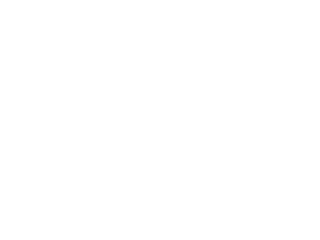

In [38]:
# Plot the surface as a mesh
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)

This creates an ablating surface (such that you are subtracting gaussian bumps instead of adding)

In [39]:
# Calculate the gradient squared (Z2)
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
# ax = plt.figure().gca(projection='3d')
# ax.plot_surface(xgrid[1:, 1:], ygrid[1:, 1:], Z2)

[3 4 5 6 7 8 9]


<IPython.core.display.Javascript object>


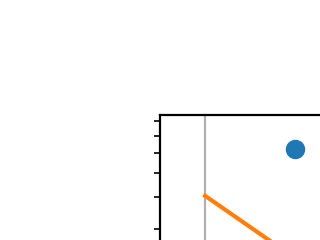

In [40]:
# Get the probability distribution
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
counts, bins = np.histogram(Z2flat)
counts = counts/np.sum(counts)
# print(counts)
# print(bins)
subset = np.array([i for i in range(4,len(bins))])-1
print(subset)
newbins = bins[1:]
logcounts = np.log(counts[subset])
p = np.polyfit(newbins[subset], logcounts, 1)
sigma = 1/(-p[0])**.5
sigma = int(sigma*1000)/1000
fig2 = plt.figure()
plt.semilogy(newbins, counts, 'o', label='Numerical result')
plt.semilogy(bins, np.exp(np.polyval(p,bins)), label=r'$\sigma = $'+str(sigma))
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.legend()

In [41]:
# For comparison, the theoretical prediction
sigma_theory = 1/(np.sqrt(4.25*np.exp(1))*Sigma)
print(sigma_theory)

0.294210585314


In [42]:
# get the dimensions 
nx,ny = np.shape(sollast)

# define the bottom of the skirt
bottom = np.min(sollast)- 2


# add a row to beginning 
startrow = np.ones(ny)*bottom; #print(np.shape(startrow))

# add a row to the end
sollast1 = np.vstack ((startrow,sollast,startrow)); #print(np.shape(sollast1))
sollast2 = np.transpose(sollast1); #print(np.shape(sollast2))

# add a column to beginning
newcol = np.ones(nx+2)*bottom; #print(np.shape(newcol))

# add a column to the end
sollast3 = np.vstack ((newcol,sollast2,newcol))
sollast4 = np.transpose (sollast3)

# Update the dimensions
nytot, nxtot = np.shape(sollast4)
#print (nxtot,nytot)

In [43]:
# Save info about this run
foldername = time.ctime()
foldername = foldername.replace(':', '_')
os.mkdir(foldername)
sls.numpy2stl(sollast4, foldername+"/surface.stl", scale = dx*30, solid=False)
sls.numpy2stl(sollast, foldername+"/surface_noskirt.stl", scale = dx*30, solid=False)
fig1.savefig(foldername+"/surface.png")
fig2.savefig(foldername+"/probability.png")
cfile = open(foldername+"/parameters1.nml", "w")
cfile.write('&parameters1\n')
cfile.write('   '+"Sigma = "+str(Sigma)+"\n")
cfile.write('   '+"sigma = "+str(sigma)+"\n")
cfile.write('   '+"sigma_theory = "+str(sigma_theory)+"\n")
cfile.write('   '+"Nbumps = "+str(Nbumps)+"\n")
cfile.write('   '+"T = "+str(dT)+"\n")
cfile.write('   '+"Nx = "+str(Nx)+"\n")
cfile.write('   '+"Ny = "+str(Ny)+"\n")
cfile.write('   '+"Lx = "+str(Lx)+"\n")
cfile.write('   '+"Ly = "+str(Ly)+"\n")
cfile.write('   '+"D_x = "+str(D_x)+"\n")
cfile.write('   '+"D_y = "+str(D_y)+"\n")
cfile.write('   '+"volume = "+str(bumpvolume(Sigma, height))+"\n")
cfile.write('   '+"height = "+str(height)+"\n")
cfile.write('   '+"mean_u = "+str(mean_u)+"\n")
cfile.write('   '+"growth_rate = "+str(growth_rate)+"\n")
cfile.write('/ \n')
cfile.close()
#save grid itself without skirt
np.savetxt(foldername+"/surface1.txt", sollast)

Creating top mesh...
Creating top mesh...
